# Abundance maps

Generate large scale maps of abundance of individual branches using a 50km grid.

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Load all buildings represented as points.

In [2]:
complete = gpd.read_parquet("/data/uscuni-boundaries/classification/")

Map ids to level 3.

In [3]:
final_clusters = pd.read_parquet(
    "/data/uscuni-ulce/processed_data/clusters/cluster_mapping_v10.pq"
)
complete["level_3"] = complete.final_without_noise.map(final_clusters[3])

Make a grid

In [4]:
grid_size = 50_000

In [5]:
bds = complete.total_bounds
bds

array([4031349.95272902, 2597498.33419905, 5378847.07173358,
       3799811.41843362])

In [6]:
x = np.arange(bds[0], bds[2], grid_size)
y = np.arange(bds[1], bds[3], grid_size)

In [7]:
xs, ys = np.meshgrid(x, y)

In [8]:
grid = gpd.GeoSeries.from_xy(x=xs.flatten(), y=ys.flatten(), crs=complete.crs).buffer(
    grid_size / 2, cap_style="square"
)

Join grid label to points

In [9]:
grid = grid.to_frame("geometry")
joined = complete.sjoin(grid, predicate="within")

Group by grid label and get counts by class.

In [22]:
counts = joined.groupby("index_right").level_3.value_counts().unstack().fillna(0)
counts = counts.div(counts.sum(axis=1), axis=0)
counts

level_3,1,2,3,4,5,6,7,8
index_right,,,,,,,,
10,0.048058,0.000000,0.076894,0.327566,0.357170,0.000000,0.123799,0.066513
11,0.021217,0.017739,0.076501,0.446203,0.304389,0.000000,0.100640,0.033311
12,0.061029,0.020410,0.008427,0.329159,0.335203,0.018215,0.206291,0.021266
13,0.005189,0.006780,0.114497,0.413747,0.361064,0.006296,0.078280,0.014148
32,0.000906,0.000000,0.114096,0.523695,0.155448,0.000000,0.128584,0.077271
...,...,...,...,...,...,...,...,...
647,0.026138,0.010807,0.444686,0.191389,0.190456,0.000000,0.136489,0.000035
670,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
671,0.000000,0.000000,0.268827,0.473730,0.247811,0.000000,0.000000,0.009632


Plot

In [23]:
grid_data = pd.concat([grid, counts], axis=1)

In [24]:
boundaries = gpd.read_file(
    "/data/uscuni-boundaries/impact_boundaries.gpkg",
    layer="1994_political",
)

In [25]:
lt = gpd.read_file(
    "https://media.githubusercontent.com/media/wmgeolab/geoBoundaries/9469f09592ced973a3448cf66b6100b741b64c0d/releaseData/gbOpen/LTU/ADM0/geoBoundaries-LTU-ADM0-all.zip",
    layer="geoBoundaries-LTU-ADM0_simplified",
).to_crs(boundaries.crs)

In [26]:
cmap = [
    "#4069BC",
    "#7CBAE4",
    "#E69C63",
    "#eec1d5",
    "#E0665F",
    "#ECBF43",
    "#b2cd32",
    "#1F943E",
]
cmap = {i: col for i, col in enumerate(cmap, 1)}

names = {
    1: "Incoherent Large-Scale \nHomogeneous Fabric",
    2: "Incoherent Large-Scale \nHeterogeneous Fabric",
    3: "Incoherent Small-Scale \nLinear Fabric",
    4: "Incoherent Small-Scale \nSparse Fabric",
    5: "Incoherent Small-Scale \nCompact Fabric",
    6: "Coherent Interconnected \nFabric",
    7: "Coherent Dense Disjoint \nFabric",
    8: "Coherent Dense Adjacent \nFabric",
}

In [27]:
def plot_label(label, ax):
    grid_data.plot(
        ax=ax,
        color=cmap[label],
        alpha=grid_data[label].fillna(0) / grid_data[label].max(),
    )
    boundaries.boundary.plot(ax=ax, color="k", zorder=2, linewidth=0.5)
    lt.boundary.plot(ax=ax, color="k", zorder=2, linewidth=0.5)

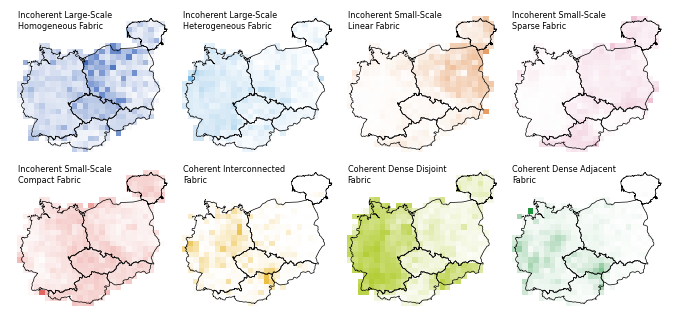

In [28]:
fig, axs = plt.subplots(2, 4, figsize=(8.5, 4), sharex=True, sharey=True)
for label, ax in enumerate(axs.flat, 1):
    plot_label(label, ax)
    ax.set_axis_off()
    ax.text(
        0.05,
        0.99,
        names[label],
        fontsize="xx-small",
        transform=ax.transAxes,
        verticalalignment="top",
    )
fig.subplots_adjust(wspace=0.00, hspace=0.00)
# fig.savefig("../data/abundance.png", bbox_inches="tight", dpi=300)